# Process data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (50 random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

sys.path.append("../")
from functions import generate_labeled_data, utils, pipeline

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/ranked_pathways/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "Rank_pathways",
                                           "init_config.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']

### Download subset of recount2 to use as a compendium
The compendium will be composed of random experiments + the selected template experiment

In [4]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
BiocManager::install("recount")

In [5]:
%%R
library('recount')

In [6]:
#%%R -i project_id -i base_dir -i local_dir

#source('../functions/download_recount2_data.R')

#get_recount2_compendium(project_id, base_dir, local_dir)

### Download expression data for selected project id

In [7]:
%%R -i project_id -i local_dir

source('../functions/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

Loading objects:
  rse_gene


### Subset genes
For our downstream we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [8]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [9]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [10]:
# Get list of our genes
# Load real template experiment
template_data_file = os.path.join(
    local_dir,
    "recount2_template_data.tsv")

# Read template data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

gene_ids = list(template_data.columns)

In [11]:
# Read file mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

gene_id_mapping = pd.read_csv(
    gene_id_file,
    header=0,
    sep='\t',
    index_col=0)

In [12]:
"""gene_ids_hgnc = {}
for gene_id in gene_ids:
    gene_id_strip = gene_id.split(".")[0]
    if gene_id_strip in list(gene_id_mapping.index):
        if len(gene_id_mapping.loc[gene_id_strip]) > 1:
            gene_ids_hgnc[gene_id] = gene_id_mapping.loc[gene_id_strip].iloc[0][0]
        else:
            gene_ids_hgnc[gene_id] = gene_id_mapping.loc[gene_id_strip][0]

gene_ids_hgnc"""

'gene_ids_hgnc = {}\nfor gene_id in gene_ids:\n    gene_id_strip = gene_id.split(".")[0]\n    if gene_id_strip in list(gene_id_mapping.index):\n        if len(gene_id_mapping.loc[gene_id_strip]) > 1:\n            gene_ids_hgnc[gene_id] = gene_id_mapping.loc[gene_id_strip].iloc[0][0]\n        else:\n            gene_ids_hgnc[gene_id] = gene_id_mapping.loc[gene_id_strip][0]\n\ngene_ids_hgnc'

In [13]:
# Save scaler transform
gene_id_dict_file = os.path.join(
    local_dir,
    "gene_id_dict.pickle")
"""
outfile = open(gene_id_dict_file,'wb')
pickle.dump(gene_ids_hgnc,outfile)
outfile.close()"""

"\noutfile = open(gene_id_dict_file,'wb')\npickle.dump(gene_ids_hgnc,outfile)\noutfile.close()"

In [14]:
# Load pickled files
gene_ids_hgnc = pickle.load(open(gene_id_dict_file, "rb" ))

In [15]:
# Get intersection of gene lists
shared_genes_hgnc = set(gene_ids_hgnc.values()).intersection(published_generic_genes)
print(len(shared_genes_hgnc))

17787


In [16]:
# Convert shared gene ids back to ensembl ids
shared_genes = []
for gene_ensembl, gene_hgnc in gene_ids_hgnc.items():
    if gene_hgnc in shared_genes_hgnc:
        shared_genes.append(gene_ensembl)

In [27]:
# Save shared genes
shared_genes_file = os.path.join(
    local_dir,
    "shared_gene_ids.pickle")

outfile = open(shared_genes_file,'wb')
pickle.dump(shared_genes,outfile)
outfile.close()

Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](0_explore_input_data.ipynb)

In [17]:
# Drop smRNA samples so that samples are within the same range
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

In [18]:
# Drop samples
template_data = template_data.drop(smRNA_samples)

In [19]:
# Drop genes
template_data = template_data[shared_genes]

print(template_data.shape)
template_data.head()

(24, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR493937,3.800154,0.018190,9.128459,1.585803,0.713952,84.990542,19.943002,12.065586,2.498822,7.713002,...,0.070696,0.367378,1.253800,1.380639,0.248717,0.000000,0.364095,1.545841,0.017363,3.247371
SRR493938,3.798473,0.000000,9.157669,1.456017,0.738967,85.788323,19.621252,11.738855,2.435308,7.125808,...,0.058200,0.264646,1.106618,1.194392,0.267246,0.032753,0.251331,1.596519,0.030814,3.115330
SRR493939,20.222134,0.000000,15.522072,3.944919,2.512265,8.072948,47.246078,18.866957,2.443230,12.143670,...,0.317962,1.208540,1.730494,1.278862,0.221390,0.000000,0.080517,0.431328,0.004231,1.074516
SRR493940,19.988329,0.000000,17.140304,3.977217,2.378849,7.599225,46.594458,18.921190,2.448276,12.048960,...,0.190032,1.115963,1.685777,1.424915,0.334883,0.000000,0.178681,0.516435,0.008451,1.130678
SRR493941,3.239231,0.019398,9.069316,2.181582,1.008155,17.675885,19.371137,11.759756,1.970725,6.740705,...,0.141640,0.433639,1.169011,1.167270,0.450155,0.059859,0.086198,0.537897,0.000000,5.301589


In [20]:
# Save 
template_data.to_csv(template_data_file, float_format='%.5f', sep='\t')

### Normalize compendium 

In [21]:
# Load real gene expression data
original_compendium_file = os.path.join(
    local_dir,
    "recount2_compedium_data.tsv")

In [22]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

# Drop genes
original_compendium = original_compendium[shared_genes]

print(original_compendium.shape)
original_compendium.head()

(1552, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR1604987,35.467314,0.027332,32.157194,2.358523,2.588223,0.000000,5.738176,43.607106,6.178332,11.840453,...,0.035007,0.920422,0.803339,0.001208,0.043968,0.022501,0.141368,0.864917,0.0,0.069363
SRR1604988,36.738594,0.014175,31.768894,2.441588,2.879852,0.028577,5.801958,44.476582,5.770250,11.408501,...,0.038639,0.799916,0.692222,0.001062,0.047765,0.000000,0.098722,1.158024,0.0,0.097557
SRR1604989,23.421167,0.000000,26.339462,2.416182,2.935066,0.000000,4.173785,33.963581,8.310376,11.857877,...,0.078934,0.570890,1.095978,0.000000,0.000000,0.000000,0.064542,3.023200,0.0,0.048292
SRR1604990,22.413470,0.000000,26.680954,2.747019,3.281573,0.009275,4.233309,33.615684,8.207437,12.296103,...,0.108039,0.484723,1.190653,0.000000,0.008279,0.000000,0.025590,2.816411,0.0,0.035656
SRR1604991,22.274276,0.000000,28.510716,1.818116,2.095023,0.011248,3.693352,32.073188,4.571614,11.777791,...,0.001030,0.406191,0.635095,0.000000,0.001343,0.000000,0.399550,2.006458,0.0,0.006592


In [29]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(1552, 17810)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000281909.1,ENSG00000281912.1,ENSG00000282458.1,ENSG00000282608.1,ENSG00000283122.1,ENSG00000283307.1,ENSG00000283440.1,ENSG00000283486.1,ENSG00000283597.1,ENSG00000283632.1
SRR1604987,0.447304,0.001928,0.148169,0.039812,0.086324,0.000000,0.050946,0.314943,0.108413,0.398045,...,0.002882,0.064611,0.062455,0.000084,0.003255,0.00412,0.004078,0.038199,0.0,0.003251
SRR1604988,0.463337,0.001000,0.146380,0.041214,0.096051,0.000053,0.051512,0.321223,0.101253,0.383524,...,0.003181,0.056152,0.053817,0.000074,0.003537,0.00000,0.002848,0.051144,0.0,0.004573
SRR1604989,0.295382,0.000000,0.121363,0.040786,0.097892,0.000000,0.037057,0.245295,0.145825,0.398631,...,0.006498,0.040075,0.085207,0.000000,0.000000,0.00000,0.001862,0.133519,0.0,0.002264
SRR1604990,0.282673,0.000000,0.122936,0.046370,0.109449,0.000017,0.037585,0.242782,0.144019,0.413363,...,0.008894,0.034026,0.092567,0.000000,0.000613,0.00000,0.000738,0.124386,0.0,0.001671
SRR1604991,0.280917,0.000000,0.131367,0.030690,0.069874,0.000021,0.032791,0.231642,0.080220,0.395938,...,0.000085,0.028514,0.049375,0.000000,0.000099,0.00000,0.011526,0.088615,0.0,0.000309


In [28]:
# Save data
normalized_data_file = os.path.join(
    local_dir,
    "normalized_recount2_compendium_data.tsv")

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

original_compendium.to_csv(
    original_compendium_file, float_format='%.3f', sep='\t')

# Save scaler transform
scaler_file = os.path.join(
    local_dir,
    "scaler_transform.pickle")

outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 

In [25]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 1552 samples and 17810 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.
Train on 1397 samples, validate on 155 samples
Epoch 1/40
1397/1397 [==============================] - 210s 150ms/step - loss: 3926.2070 - val_loss: 3459.0191
Epoch 2/40
1397/1397 [==============================] - 210s 150ms/step - loss: 3467.0427 - val_loss: 3343.8459
Epoch 3/40
1397/1397 [==============================] - 210s 150ms/step - loss: 3423.9788 - val_loss: 3339.6351
Epoch 4/40
1397/1397 [==============================] - 210s 151ms/step - loss: 3396.0255 - val_loss: 3249.9468
Epoch 5/40
1397/1397 [==============================] - 212s 152ms/step - loss: 3366.7077 - val_loss: 3258.3494
Epoch 6/40
1397/1397 [==============================] - 212s 151ms/step - loss: 3328.9001 - val_loss: 3232.9764
Epoch 7/40
1397/1397 [=======================

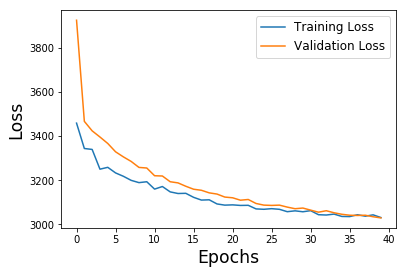

In [26]:
# Train VAE on new compendium data
# Write out model to rank_pathways directory
pipeline.train_vae(config_file,
                   normalized_data_file)